## AI Session 8 (Lab 1) - Word embeddings in NLP



### Refeerences:
- "NLP - Word Embedding approaches" [Abdallah Wagih Ibrahim, Kaggle notebook](https://www.kaggle.com/code/abdallahwagih/nlp-word-embedding-approaches)
- "Using Word Embeddings for Sentiment Analysis" [Bert Carremans, Kaggle notebook](https://www.kaggle.com/code/bertcarremans/using-word-embeddings-for-sentiment-analysis)
- "Tokenizer & TextVectorization ?Difference !!!" [Bishal sharma, Medium Blog](https://medium.com/@bishalsharma406365/tokenizer-textvectorization-difference-2ddb67b20b01)
- "Word Embeddings for Sentiment Analysis" [Hey Amit, Medium Blog](https://medium.com/we-talk-data/word-embeddings-for-sentiment-analysis-0535f1ffad57)
- "A Complete Step by Step Tutorial on Sentiment Analysis in Keras and Tensorflow" [Rashida Nasrin Sucky, Medium blog in "Towards Data Science"](https://medium.com/data-science/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f)
- "Sentiment Classification using Word Embeddings (Word2Vec)" [Dipika Baad, Medium Blog](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)

### General notes:

- Word embeddings provide a much more robust way of embedding texk when compared to BOW and TF-IDF technques explored in the last session
- BOW and TF-IDF provide sparse vector embeddings which can be inefficient, they lack the property of word ordering, context ans semantic similarity

There are broadly 2 types of word embedding techniques, namely:
 - Continuiuos Bag of Words (CBOW)
 - Skip Gram (SG)

### Imports

In [1]:
from typing import List, Tuple, Dict, Any
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
import random
import collections
import re
# import emoji
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)
pd.set_option('max_colwidth', 600)

### Load the pre-trained Google News Vector

In [2]:
%%time

# Path to dataset
word2vec_path = "./models/GoogleNews-vectors-negative300.bin"

# Load 200,000 most common words
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

CPU times: total: 4.34 s
Wall time: 4.37 s


### Convert the model (keyed vectors) to a python dictionary

In [3]:
def convert_keyed_vectors_2_dict(word2vec_model: gensim.models.keyedvectors.KeyedVectors) -> Dict[str, np.array]:
    """
    Converts the KeyedVectors object to a python dictionary
    :param word2vec_model: Word2vec model
    :returns: Dictionary of words (keys) and vectors (values)
    """
    word_vectors_dict = {word: word2vec_model[word] for word in word2vec_model.index_to_key}


#### Sample a word vector

In [4]:
# Get word vector
test_word = "science"
science = word2vec_model[test_word]

# Print shape and vector
print(f"Vector dimension: {science.shape}")
print(f"science[:10]: {science[:10]}")

Vector dimension: (300,)
science[:10]: [ 0.0090332   0.12158203  0.3984375   0.21386719 -0.01672363  0.06396484
  0.3125     -0.23535156 -0.10009766 -0.09326172]


#### Anaysis of word similary:
- Analyse the similarity between "science" and words: "chemistry", "history", "politics", "physics", "technology", "music"

In [10]:
subjects = ["chemistry", "history", "politics", "physics", "technology", "music"]
for subject in subjects:
    word_similarity = word2vec_model.similarity(test_word, subject)
    print(f"similarity b/w {test_word} and {subject} is {word_similarity}")

similarity b/w science and chemistry is 0.42221927642822266
similarity b/w science and history is 0.21971957385540009
similarity b/w science and politics is 0.36579227447509766
similarity b/w science and physics is 0.5928831100463867
similarity b/w science and technology is 0.4275681972503662
similarity b/w science and music is 0.22354593873023987


#### Compute sentence similarity:
- It takes the averages of the each sentence word vectors and computes the cosine similarity b/w the sentences
- Here is a simple example:
  - Sentence 1: "Man is running"
  - Sentence 2: "Woman is swimming"

In [36]:
def compute_sentence_similarity(first_sentence: str, second_sentence:str) -> float:
    """
    Computes the similarity of sentences
    :param first_sentence: First sentence
    :param second_sentence: Second sentence
    :returns: Similarity score b/w 0 and 1    
    """
    return word2vec_model.n_similarity(first_sentence.split(), second_sentence.split())

def compute_sentence_similarity_2(first_sentence: str, second_sentence:str) -> float:
    """
    Computes the similarity of sentences
    :param first_sentence: First sentence
    :param second_sentence: Second sentence
    :returns: Similarity score b/w 0 and 1    
    """
    def get_embedding_vector(word: str) -> np.array:
        """
        Gets the embedding vector for a specified word.
        If the word is "Out Of Vocabulary" (OOV) then a random vector is used
        :param word: Input word
        :returns: Word embedding vector
        """
        word_vectors = word2vec_model.key_to_index
        if word in word_vectors:
            return word2vec_model[word]
        else:
            return np.array(np.random.uniform(-1.0, 1.0, 300))
            
    first_sentence_vectors = [get_embedding_vector(word) for word in first_sentence.split()]
    second_sentence_vectors = [get_embedding_vector(word) for word in second_sentence.split()]
    v1 = np.mean(first_sentence_vectors, axis=0)
    v2 = np.mean(second_sentence_vectors, axis=0)
    print(f"v1: {v1.shape}")
    print(f"v2: {v2.shape}")
    cosine_sim = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return cosine_sim
    
first_sentence = "Man is running"
second_sentence = "Woman is swimming"
sentence_similarity = compute_sentence_similarity(first_sentence, second_sentence)
sentence_similarity = compute_sentence_similarity_2(first_sentence, second_sentence)

print(f"The similarity score between {first_sentence} and {second_sentence} is: {sentence_similarity}")

v1: (300,)
v2: (300,)
The similarity score between Man is running and Woman is swimming is: 0.6135290265083313


#### Compute the top n words similar to a specified word
- What are the top 10 most similar words to "doctor" and "policeman"

In [12]:
def compute_top_n_similar_words(word: str, top_n: int = 10) -> List[Tuple[str, float]]:
    """
    Computes the top n similar words to a specified word
    :param word: Specified word
    :param top_n: Top n value
    :returns: List of top n similar words
    """
    return word2vec_model.most_similar(positive=[word], topn=top_n)

words = ["doctor", "policeman"]
for word in words:
    print(f"Similar words to {word} are:")
    pprint(compute_top_n_similar_words(word))
    print("\n\n")


Similar words to doctor are:
[('physician', 0.7806021571159363),
 ('doctors', 0.747657299041748),
 ('gynecologist', 0.6947518587112427),
 ('surgeon', 0.6793398261070251),
 ('dentist', 0.6785441040992737),
 ('pediatrician', 0.664313793182373),
 ('pharmacist', 0.653485894203186),
 ('neurologist', 0.6517742872238159),
 ('cardiologist', 0.6352297067642212),
 ('nurse', 0.6319523453712463)]



Similar words to policeman are:
[('policewoman', 0.7279600501060486),
 ('policemen', 0.7010903358459473),
 ('Policeman', 0.6895388960838318),
 ('constable', 0.675649881362915),
 ('cop', 0.6574562788009644),
 ('taxi_driver', 0.6495267152786255),
 ('soldier', 0.6210582852363586),
 ('sergeant', 0.6108294725418091),
 ('police', 0.6099761128425598),
 ('patrolman', 0.5841509699821472)]





#### Visualize semantic similarity of the word vectors (embeddings):
- To do this we will need to use dimensionality reduction technique like Principal Component Analysis (PCA) to reduce each vector dimension from 300 to 2
- This will enable the visualization in 2-d space
- We will visualize a diverse list of words such as:
  - "policeman", "soldier", "colonel", "gunner", "football","tennis","rugby",
                "river","ocean","water","rugby", "man", "woman", "cat", "tiger", "dog"

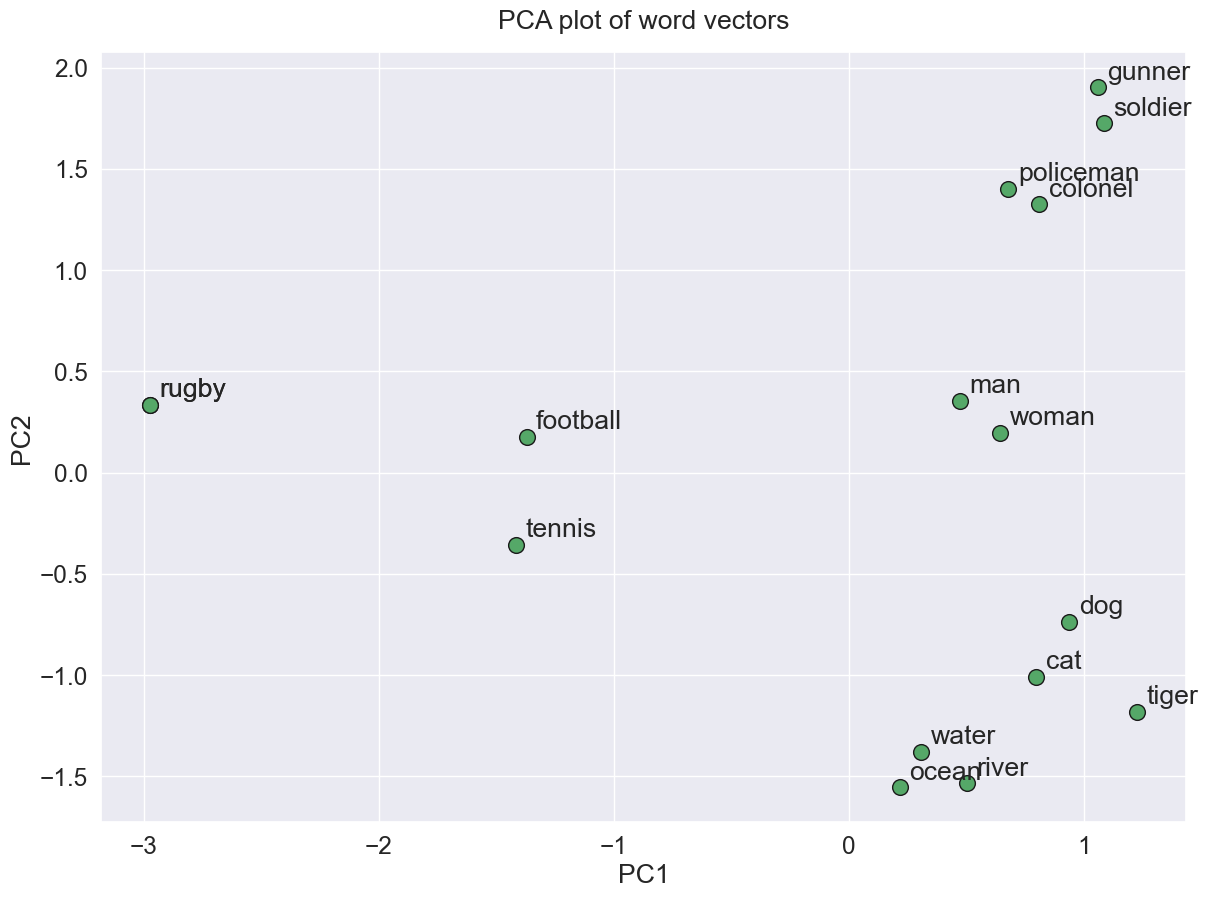

In [13]:
def visualize_word_similarities(words: List[str]) -> None:
    """
    Plots a 2-d visualization of a collection of words
    It uses PCA to reduce the dimensionality of each vector to 2 and plots spacial representation of each word
    :param words: List of words
    :returns: None
    """
    word_vectors = np.array([word2vec_model[w] for w in words])

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(word_vectors)
    
    # Plot transformed vectors
    plt.figure(figsize=(14,10))
    plt.scatter(X_pca[:,0], X_pca[:,1], edgecolors='k', c='g', s=128)
    for word, (x,y) in zip(words, X_pca):
        plt.text(x+0.04,y+0.04, word)
    plt.title("PCA plot of word vectors", y=1.02)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


sample_words = ["policeman", "soldier", "colonel", "gunner", "football","tennis","rugby",
                "river","ocean","water","rugby", "man", "woman", "cat", "tiger", "dog"]

visualize_word_similarities(sample_words)

### A quick recap on Tokenization
- Using Tensorflow - Keras tokenizer
- from tensorflow.keras.preprocessing.text import Tokenizer
- The Tokenizer class is used for text preprocessing by converting text into sequences of integers
- Each word or token in the text is mapped to a unique integer based on its frequency in the dataset.


#### Example:

- Tokenize a small corpus:
  - texts = ["I love machine learning", "Machine learning is fun"]
  - tokenizer = Tokenizer()
  - tokenizer.fit_on_texts(texts)
- Convert text to sequences
  - sequences = tokenizer.texts_to_sequences(texts)
  - print(sequences)  # [[1, 2, 3], [2, 3, 4]]

In [14]:
random_corpus = ["I love machine learning", "Machine learning is fun"]
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(random_corpus)
sequences = tokenizer.texts_to_sequences(random_corpus)
print(sequences)

[[3, 4, 1, 2], [1, 2, 5, 6]]
